In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error

file_path = "../data/household_power_consumption.txt"

df = pd.read_csv(
    file_path,
    sep=";",
    low_memory=False,
    na_values="?"
)

print("Dataset Loaded Successfully!")
df.head()


Dataset Loaded Successfully!


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


Missing Values:
Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


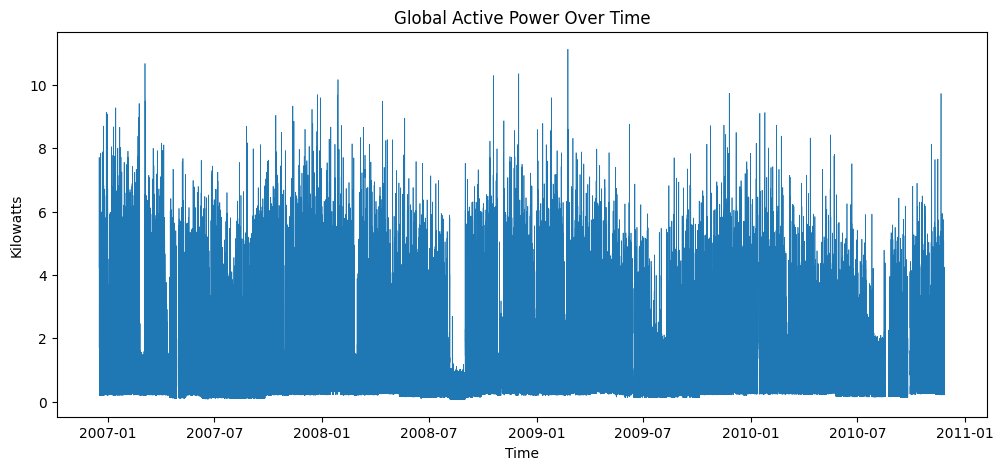

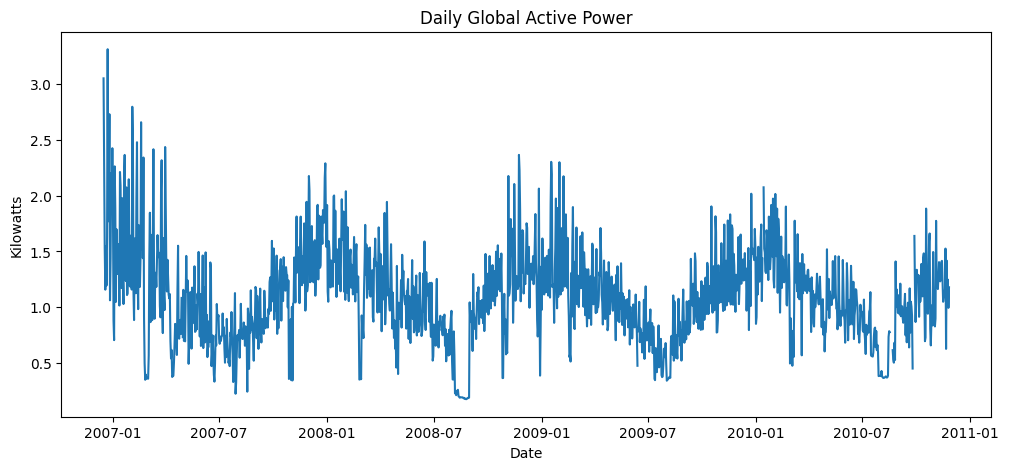

In [ ]:

df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')

df.sort_values('Datetime', inplace=True)
df.set_index('Datetime', inplace=True)

numeric_cols = [
    'Global_active_power', 'Global_reactive_power', 
    'Voltage', 'Global_intensity',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]
df[numeric_cols] = df[numeric_cols].astype(float)


print("Missing Values:")
print(df.isnull().sum())

plt.figure(figsize=(12,5))
plt.plot(df['Global_active_power'], linewidth=0.5)
plt.title("Global Active Power Over Time")
plt.xlabel("Time")
plt.ylabel("Kilowatts")
plt.show()


daily_usage = df['Global_active_power'].resample('D').mean()

plt.figure(figsize=(12,5))
plt.plot(daily_usage)
plt.title("Daily Global Active Power")
plt.xlabel("Date")
plt.ylabel("Kilowatts")
plt.show()


In [ ]:

df_model = df[['Global_active_power']].dropna()


df_model['Target'] = df_model['Global_active_power'].shift(-1)
df_model.dropna(inplace=True)


train_size = int(len(df_model)*0.8)
train = df_model.iloc[:train_size]
test  = df_model.iloc[train_size:]

X_train = train[['Global_active_power']]
y_train = train['Target']

X_test = test[['Global_active_power']]
y_test = test['Target']


In [9]:
model = RandomForestRegressor(n_estimators=50)
model.fit(X_train, y_train)

predictions = model.predict(X_test)


In [10]:
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 0.0805782838147312
RMSE: 0.21973466162714655


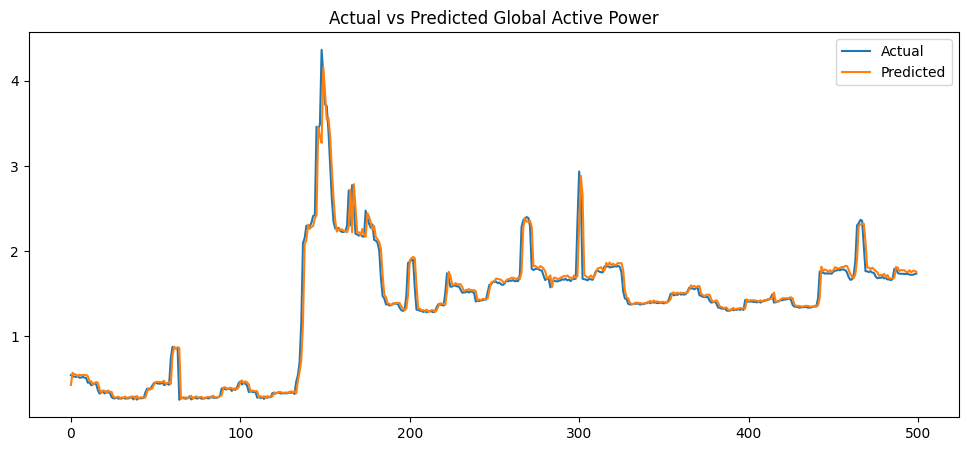

In [11]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:500], label="Actual")
plt.plot(predictions[:500], label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Global Active Power")
plt.show()


In [ ]:
daily_df = df['Global_active_power'].resample('D').sum().dropna()
daily_df = daily_df.to_frame(name='DailyConsumption')

kmeans = KMeans(n_clusters=3, random_state=42)
daily_df['Cluster'] = kmeans.fit_predict(daily_df[['DailyConsumption']])


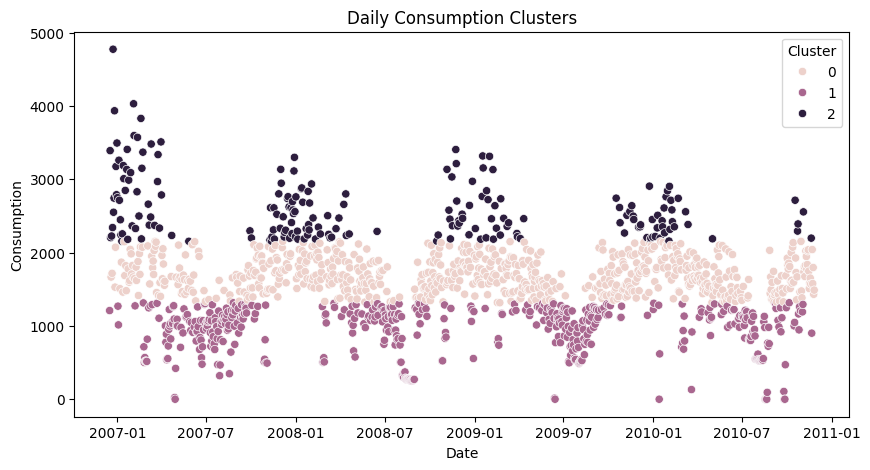

In [13]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=daily_df, x=daily_df.index, y='DailyConsumption', hue='Cluster')
plt.title("Daily Consumption Clusters")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.show()


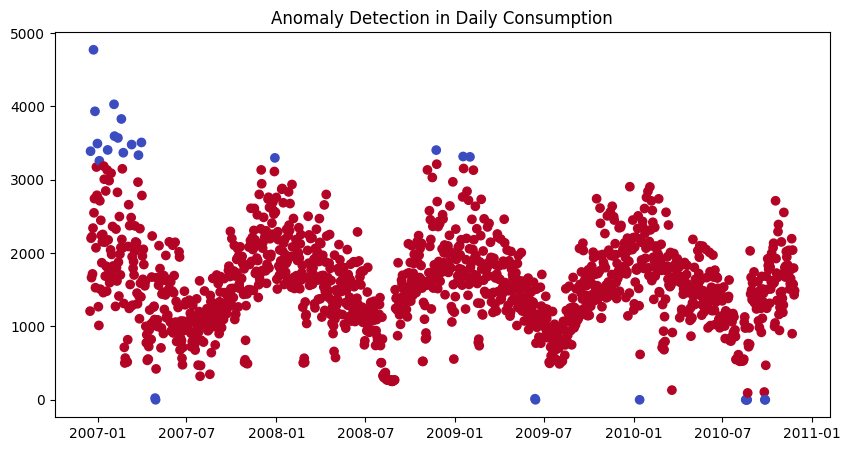

In [14]:
iso = IsolationForest(contamination=0.02)
daily_df['Anomaly'] = iso.fit_predict(daily_df[['DailyConsumption']])

plt.figure(figsize=(10,5))
plt.scatter(daily_df.index, daily_df['DailyConsumption'], 
            c=daily_df['Anomaly'], cmap='coolwarm')
plt.title("Anomaly Detection in Daily Consumption")
plt.show()


In [16]:
def consumption_category(value):
    if value < 1.5:
        return "Low Usage", "Try switching to energy-efficient appliances!"
    elif value < 3.0:
        return "Medium Usage", "Turn off unused devices to save energy."
    else:
        return "High Usage", "Consider reducing AC/heater usage to save power."

latest_value = df['Global_active_power'].iloc[-1]

category, advice = consumption_category(latest_value)

print("Latest Consumption:", latest_value)
print("Category:", category)
print("AI Suggestion:", advice)


Latest Consumption: 0.932
Category: Low Usage
AI Suggestion: Try switching to energy-efficient appliances!
